**<h1> NYC TAXI TRIPS TRAFFIC ANALYSIS </h1>**

** <h2>PART1 : INTRODUCTION </h2>**

**In this part as a WARM UP I will focus on the preparation of the necessary environment in order to perform the necessary tasks for the analysis and the extraction of the data value. 
first of all the import of the necessary libraries  the preparation of the environment for massive data processing **

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# actually the necessary librairy for large scale processing (pyspark) is not provided natively with the notebook provided by kaggle.

!pip install pyspark

import numpy as np #  for linear algebra
import pandas as pd # for data processing

#necessary for introducing the work environment
from pyspark import SparkContext
from pyspark.sql import SparkSession

# necessary for doing analysis & evaluations using plots a designing evaluations machine learning models
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# necessary for using sql in large scale as a large scale processing purpose.
from pyspark.sql.functions import *
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.types import DateType, TimestampType, IntegerType
from pyspark.sql.functions import col, lag, unix_timestamp,udf
from pyspark.sql.window import Window

# necessary librairies for time & system management.
from dateutil import parser
import datetime
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2011-json_corrigido.json
/kaggle/input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2009-json_corrigido.json
/kaggle/input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2010-json_corrigido.json
/kaggle/input/csvsupportfiles/data-payment_lookup-csv.csv
/kaggle/input/csvsupportfiles/data-vendor_lookup-csv.csv
/kaggle/input/nyctripstaxidataset/data-sample_data-nyctaxi-trips-2012-json_corrigido.json


**Below are introduced the datasets that i'm gonna work with during my analysis in this notebook**
*I'll only work with the files in json format because the other files contain data that i judge useless for my problem data analysis*

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 204.2 MB 28 kB/s s eta 0:00:01     |██████████████████████████████  | 190.8 MB 47.9 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 40.8 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=c14b67018eeebac125cce5991837b5434746b714fa8a7e9aa24878c88f4d52cb
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


**Introducing the environement for work on large scale data processing**

In [3]:
sc = SparkContext(appName = "MyApplication")
spark = SparkSession.Builder().getOrCreate()

** <h2> PART 2 : EXTRACT TRANSFORM LOAD </h2>**

**In this part i focus on the pre-processing & processing of the datasets all kinds of extracting transformations cleaning to make the data exploitable for the analysis & since it's a data of 1.6GB of information my choice is to do all the process using librairies on python for stocking & processing in a distributed way because it's the efficient and possible way to do that some simple queries on simple dataframe cost me almost 10 minutes & sometimes more so large scale processing here is a must**

**Load the datasets used for analysis 1.6GB of taxi traffic data in new york**

In [4]:
nyctaxidata_2009= spark.read.json(r'../input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2009-json_corrigido.json')
nyctaxidata_2010= spark.read.json(r'../input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2010-json_corrigido.json')
nyctaxidata_2011= spark.read.json(r'../input/nyc-trips-taxi-dataset/data-sample_data-nyctaxi-trips-2011-json_corrigido.json')
nyctaxidata_2012= spark.read.json(r'../input/nyctripstaxidataset/data-sample_data-nyctaxi-trips-2012-json_corrigido.json')


*Counting the number of lines in each dataset to be sure that the load has done right*

In [5]:
print(nyctaxidata_2009.count())
print(nyctaxidata_2010.count())
print(nyctaxidata_2011.count())
print(nyctaxidata_2012.count())

*This cell is designed in purpose to merge the datasets on and unique for analysis*

In [6]:
nyc_taxi_data = nyctaxidata_2009.union(nyctaxidata_2010.union(nyctaxidata_2011.union(nyctaxidata_2012)))
print(nyc_taxi_data.count())


1000000
1000000
1000000
1000000


In [7]:
nyc_taxi_data

4000000


*Inspecting the columns and types provided in dataset *

In [9]:
types_data = [t for t in nyc_taxi_data.schema.fields]
types_data

[StructField(dropoff_datetime,StringType,true),
 StructField(dropoff_latitude,DoubleType,true),
 StructField(dropoff_longitude,DoubleType,true),
 StructField(fare_amount,DoubleType,true),
 StructField(passenger_count,LongType,true),
 StructField(payment_type,StringType,true),
 StructField(pickup_datetime,StringType,true),
 StructField(pickup_latitude,DoubleType,true),
 StructField(pickup_longitude,DoubleType,true),
 StructField(rate_code,StringType,true),
 StructField(store_and_fwd_flag,LongType,true),
 StructField(surcharge,DoubleType,true),
 StructField(tip_amount,DoubleType,true),
 StructField(tolls_amount,DoubleType,true),
 StructField(total_amount,DoubleType,true),
 StructField(trip_distance,DoubleType,true),
 StructField(vendor_id,StringType,true)]

*Inspecting the number of distinct values for each column in the dataset*

In [11]:
for column in nyc_taxi_data.columns:
    print(nyc_taxi_data.agg(countDistinct(col(column)).alias("disinct value : "+column)).show())

+--------------------------------+
|disinct value : dropoff_datetime|
+--------------------------------+
|                         4000000|
+--------------------------------+

None
+--------------------------------+
|disinct value : dropoff_latitude|
+--------------------------------+
|                          146071|
+--------------------------------+

None
+---------------------------------+
|disinct value : dropoff_longitude|
+---------------------------------+
|                           121212|
+---------------------------------+

None
+---------------------------+
|disinct value : fare_amount|
+---------------------------+
|                        821|
+---------------------------+

None
+-------------------------------+
|disinct value : passenger_count|
+-------------------------------+
|                              7|
+-------------------------------+

None
+----------------------------+
|disinct value : payment_type|
+----------------------------+
|                          

1. > RE : 1 _ Average distance traveled by trips with a maximum of 2 passengers

**This query written using spark sql to extract the average tripdistance for trips that doesn't exceed 2 passengers **

In [12]:
nyc_taxi_data.createTempView("taxi_table")
spark.sql("SELECT avg(trip_distance) as AVERAGE FROM taxi_table WHERE passenger_count <=2").show()

+------------------+
|           AVERAGE|
+------------------+
|2.6625269962032303|
+------------------+



> RE : 2 _  The 3 biggest vendors based on the total amount of money raised

**This query written using spark sql to show the 3 vendors who made the more money**

In [13]:
spark.sql("SELECT sum(total_amount) as MONEY from taxi_table GROUP BY vendor_id ORDER BY money DESC LIMIT 3").show()


+--------------------+
|               MONEY|
+--------------------+
| 1.954908428000008E7|
|1.9043433999999914E7|
|  2714901.7200000025|
+--------------------+



*The next 4 cells of code is designed for converting the dates from string format to TIMESTAMPTYPE and show them respectively for preprocessing purpose * 

In [15]:
udf_myconverter = udf(parser.parse, TimestampType()) 
nyc_taxi_data = nyc_taxi_data.withColumn("dropoff_datetime_converted", udf_myconverter("dropoff_datetime")) 

In [16]:
nyc_taxi_data.select("dropoff_datetime_converted").show()

+--------------------------+
|dropoff_datetime_converted|
+--------------------------+
|      2009-04-21 18:57:...|
|      2009-01-13 07:50:...|
|      2009-01-06 19:43:...|
|      2009-09-24 08:41:...|
|      2009-10-29 05:57:...|
|      2009-10-23 17:23:...|
|      2009-03-30 09:47:...|
|      2009-03-18 18:02:...|
|      2009-03-30 13:32:...|
|      2009-02-20 18:11:...|
|      2009-06-27 16:51:...|
|      2009-03-04 21:36:...|
|      2009-02-10 04:54:...|
|      2009-06-23 18:34:...|
|      2009-11-17 05:00:...|
|      2009-02-08 06:41:...|
|      2009-05-11 02:20:...|
|      2009-05-22 22:29:...|
|      2009-11-06 15:57:...|
|      2009-02-09 04:47:...|
+--------------------------+
only showing top 20 rows



In [17]:
udf_myconverter = udf(parser.parse, TimestampType()) 
nyc_taxi_data = nyc_taxi_data.withColumn("pickup_datetime_converted", udf_myconverter("pickup_datetime")) 

In [18]:
nyc_taxi_data.select("pickup_datetime_converted").show()

+-------------------------+
|pickup_datetime_converted|
+-------------------------+
|     2009-04-21 18:51:...|
|     2009-01-13 07:40:...|
|     2009-01-06 19:30:...|
|     2009-09-24 08:28:...|
|     2009-10-29 05:50:...|
|     2009-10-23 17:14:...|
|     2009-03-30 09:41:...|
|     2009-03-18 17:56:...|
|     2009-03-30 13:21:...|
|     2009-02-20 18:06:...|
|     2009-06-27 16:40:...|
|     2009-03-04 21:26:...|
|     2009-02-10 04:47:...|
|     2009-06-23 18:24:...|
|     2009-11-17 04:51:...|
|     2009-02-08 06:32:...|
|     2009-05-11 02:09:...|
|     2009-05-22 22:21:...|
|     2009-11-06 15:46:...|
|     2009-02-09 04:41:...|
+-------------------------+
only showing top 20 rows



*Creating a column that describes the date for each trip in the dataset and show it as preprocessing purpose*

In [19]:
udf_myconverter = udf(parser.parse, DateType()) 
nyc_taxi_data = nyc_taxi_data.withColumn("Trip_date", udf_myconverter("dropoff_datetime")) 

In [20]:
nyc_taxi_data.select("Trip_date").show()

+----------+
| Trip_date|
+----------+
|2009-04-21|
|2009-01-13|
|2009-01-06|
|2009-09-24|
|2009-10-29|
|2009-10-23|
|2009-03-30|
|2009-03-18|
|2009-03-30|
|2009-02-20|
|2009-06-27|
|2009-03-04|
|2009-02-10|
|2009-06-23|
|2009-11-17|
|2009-02-08|
|2009-05-11|
|2009-05-22|
|2009-11-06|
|2009-02-09|
+----------+
only showing top 20 rows



*Creating a column that describes the time spended in during the trip from the difference between the pickup time and dropoff time in a trip from calculation and showing it*

In [21]:
nyc_taxi_data = nyc_taxi_data.withColumn("Trip_time", 
   (unix_timestamp(nyc_taxi_data.dropoff_datetime_converted) - unix_timestamp(nyc_taxi_data.pickup_datetime_converted))
)

In [22]:
nyc_taxi_data.select("Trip_time").show()

+---------+
|Trip_time|
+---------+
|      358|
|      629|
|      745|
|      827|
|      403|
|      546|
|      349|
|      370|
|      648|
|      311|
|      660|
|      591|
|      431|
|      605|
|      560|
|      531|
|      694|
|      448|
|      675|
|      308|
+---------+
only showing top 20 rows



In [23]:
nyc_taxi_data.select(
    year("Trip_date").alias('year'), 
    month("Trip_date").alias('month'), 
    dayofmonth("Trip_date").alias('day'),
    dayofweek("Trip_date").alias('dayofweek')).show()


+----+-----+---+---------+
|year|month|day|dayofweek|
+----+-----+---+---------+
|2009|    4| 21|        3|
|2009|    1| 13|        3|
|2009|    1|  6|        3|
|2009|    9| 24|        5|
|2009|   10| 29|        5|
|2009|   10| 23|        6|
|2009|    3| 30|        2|
|2009|    3| 18|        4|
|2009|    3| 30|        2|
|2009|    2| 20|        6|
|2009|    6| 27|        7|
|2009|    3|  4|        4|
|2009|    2| 10|        3|
|2009|    6| 23|        3|
|2009|   11| 17|        3|
|2009|    2|  8|        1|
|2009|    5| 11|        2|
|2009|    5| 22|        6|
|2009|   11|  6|        6|
|2009|    2|  9|        2|
+----+-----+---+---------+
only showing top 20 rows



*Verifyin one more time the columns existing in the dataset *

In [24]:
nyc_taxi_data.columns

['dropoff_datetime',
 'dropoff_latitude',
 'dropoff_longitude',
 'fare_amount',
 'passenger_count',
 'payment_type',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'rate_code',
 'store_and_fwd_flag',
 'surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'trip_distance',
 'vendor_id',
 'dropoff_datetime_converted',
 'pickup_datetime_converted',
 'Trip_date',
 'Trip_time']

 *Firstly Doing some selections in the trip_date feature & selecting the features needed for the analysis part of the dataset and secondly transforming the spark dataframe into a pandas dataframe to be able to do some analysis in the next part*

In [25]:
df_plot = nyc_taxi_data.select("Trip_date","Trip_time","fare_amount","pickup_longitude","pickup_latitude","dropoff_latitude","dropoff_longitude","payment_type","tip_amount",year("Trip_date").alias('year'), 
month("Trip_date").alias('month'),dayofmonth("Trip_date").alias('day'),dayofweek("Trip_date").alias('dayofweek'))
pdf_df_plot = df_plot.toPandas()
print(pdf_df_plot.head())

    Trip_date  Trip_time  fare_amount  pickup_longitude  pickup_latitude  \
0  2009-04-21        358          5.4        -74.004114        40.742950   
1  2009-01-13        629         15.4        -73.996506        40.747784   
2  2009-01-06        745          6.1        -73.951340        40.752070   
3  2009-09-24        827         12.9        -74.001117        40.729128   
4  2009-10-29        403          7.7        -73.976600        40.756873   

   dropoff_latitude  dropoff_longitude payment_type  tip_amount  year  month  \
0         40.747950         -73.994712         Cash         0.0  2009      4   
1         40.792385         -73.940449         Cash         0.0  2009      1   
2         40.768108         -73.944535         CASH         0.0  2009      1   
3         40.721812         -73.958122         CASH         0.0  2009      9   
4         40.776075         -73.979757         CASH         0.0  2009     10   

   day  dayofweek  
0   21          3  
1   13          3  
2 

** <h2>PART3 : EXTRACTING INSIGHT FROM THE DATA AND ANALYSIS </h2>**

**In this part i'm focusing doing the processing for the analysis & showing insight with explanations **
* Plotting results & explanations of the results.
* Doing the minimal necessary processing on data for memory economy time consuming optimization processing for plotting the results. 




**Firstly verifying the types of columns after the transformation done**

In [26]:
pdf_df_plot.dtypes

Trip_date             object
Trip_time              int64
fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_latitude     float64
dropoff_longitude    float64
payment_type          object
tip_amount           float64
year                   int32
month                  int32
day                    int32
dayofweek              int32
dtype: object

**Doing the necessary type transformation & reverifying the columns types in the dataset**

In [27]:
pdf_df_plot['Trip_date'] = pd.to_datetime(pdf_df_plot['Trip_date'], format='%Y-%m-%d')
print(pdf_df_plot.dtypes)

Trip_date            datetime64[ns]
Trip_time                     int64
fare_amount                 float64
pickup_longitude            float64
pickup_latitude             float64
dropoff_latitude            float64
dropoff_longitude           float64
payment_type                 object
tip_amount                  float64
year                          int32
month                         int32
day                           int32
dayofweek                     int32
dtype: object


# All the processing done in the below 4 cells are designed for a common purpose answer the question : 
**Make a histogram of the monthly distribution over 4 years of rides paid with cash**

**Select necessary columns & lower case the payment_type column & doing the filter for a data with CASH payment trips**

In [28]:
histogram_data = pdf_df_plot[["payment_type", "Trip_date","month","year"]]           
histogram_data["payment_type"] = histogram_data["payment_type"].str.lower()
histogram_data_cash = histogram_data[histogram_data["payment_type"]=="cash"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Grouping for each date & counting the number of trips in each day**

In [29]:
histogram_data_cash = histogram_data_cash.groupby('Trip_date').size().reset_index(name='count')
histogram_data_cash.head(10)

,Trip_date,count
0,2009-01-04,2433
1,2009-01-05,2392
2,2009-01-06,2456
3,2009-01-07,2395
4,2009-01-08,2355
5,2009-01-09,2229
6,2009-01-10,2393
7,2009-01-11,2399
8,2009-01-12,2354
9,2009-01-13,2430


*Setting an index for each date*

In [30]:
histogram_data_cash = histogram_data_cash.set_index('Trip_date')
histogram_data_cash.head(10)

,count
Trip_date,
2009-01-04,2433
2009-01-05,2392
2009-01-06,2456
2009-01-07,2395
2009-01-08,2355
2009-01-09,2229
2009-01-10,2393
2009-01-11,2399
2009-01-12,2354


*Sampling and sum the counting for all the trips for each month*

In [31]:
e = histogram_data_cash['count'].resample('MS').sum()
e

Trip_date
2009-01-01    66812
2009-02-01    66680
2009-03-01    73943
2009-04-01    71142
2009-05-01    74152
2009-06-01    71346
2009-07-01    74072
2009-08-01    74022
2009-09-01    71508
2009-10-01    74014
2009-11-01    71417
2009-12-01    21605
2010-01-01    66172
2010-02-01    66830
2010-03-01    73616
2010-04-01    71076
2010-05-01    73665
2010-06-01    70984
2010-07-01    73483
2010-08-01    73365
2010-09-01    71115
2010-10-01    73642
2010-11-01    70881
2010-12-01    25884
2011-01-01    55556
2011-02-01    70980
2011-03-01    78300
2011-04-01    76119
2011-05-01    78587
2011-06-01    75727
2011-07-01    78720
2011-08-01    78854
2011-09-01    76252
2011-10-01    78571
2011-11-01    63047
2011-12-01        0
2012-01-01    80905
2012-02-01    78450
2012-03-01    83375
2012-04-01    81293
2012-05-01    83937
2012-06-01    80823
2012-07-01    84412
2012-08-01    83440
2012-09-01    81275
2012-10-01    72803
Freq: MS, Name: count, dtype: int64

> RE : 3 _Doing some analysis using ahistogram of the monthly distribution over 4 years of rides paid with cash;

*Plotting a bar for each month in the 4 years*

# **By plotting the density of trips for each month during the 4 years of provided data we can exactly from the plot observe 4 Gaussian distributions due to the seasonal behavior of taxi_trips traffic in new-york and a trend that increment a little bit after each year**

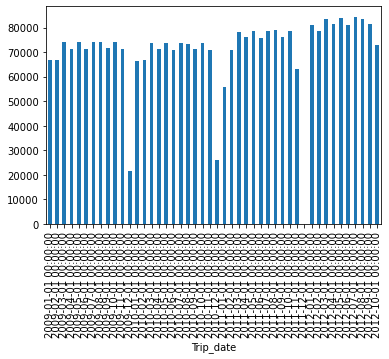

In [32]:
e.plot(kind="bar")

# All the processing done in the below 7 cells are designed for a common purpose answer the question : 
**Make a time series chart computing the number of tips each day for the last 3 months of 2012**

*Select necessary feature for the problem*

In [36]:
data_tip_chart = pdf_df_plot[["Trip_date","tip_amount"]]

*Making a group of trips in each day and summing the tip_amounts*

In [37]:
data_tip_chart = data_tip_chart.groupby('Trip_date')['tip_amount'].sum().reset_index()

*Setting an index for Trip_date*

In [38]:
data_tip_chart = data_tip_chart.set_index('Trip_date')

*Verifying if the index is done*

In [39]:
data_tip_chart.index

DatetimeIndex(['2009-01-04', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-10', '2009-01-11',
               '2009-01-12', '2009-01-13',
               ...
               '2012-10-19', '2012-10-20', '2012-10-21', '2012-10-22',
               '2012-10-23', '2012-10-24', '2012-10-25', '2012-10-26',
               '2012-10-27', '2012-10-28'],
              dtype='datetime64[ns]', name='Trip_date', length=1306, freq=None)

*Sampling tip_amounts for each business day and selecting the 3 last month of 2012 for the analysis*

In [40]:
y = data_tip_chart['tip_amount'].resample('B').mean()
y=y['2012-8-1':]

*Verifying*

In [41]:
y

Trip_date
2012-08-01    1269.220000
2012-08-02    1474.270000
2012-08-03    1306.076667
2012-08-06    1300.020000
2012-08-07    1499.120000
                 ...     
2012-10-22    1365.510000
2012-10-23    1429.350000
2012-10-24    1226.090000
2012-10-25    1259.900000
2012-10-26     875.500000
Freq: B, Name: tip_amount, Length: 63, dtype: float64

> RE : 4 _Make a time series chart computing the number of tips each day for the last 3 months of
2012.

# During the last 3 month of 2012 in business days the traffic is quite stable on a mean value. 

*Plotting the designed data using matplotlib*

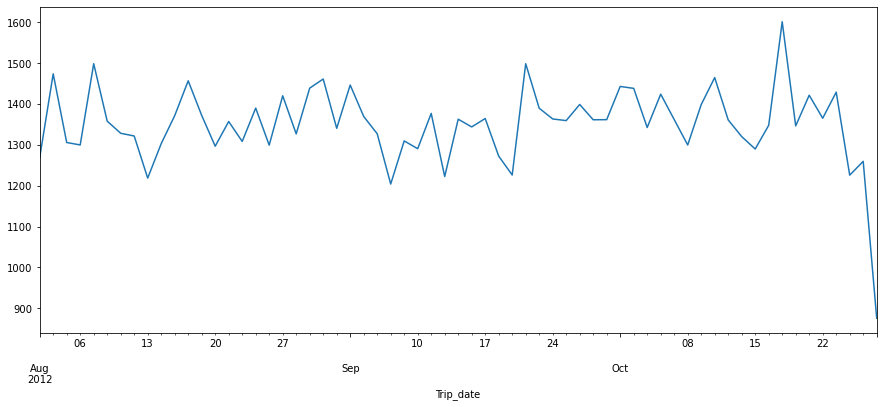

In [42]:
import matplotlib.pyplot as plt
y.plot(figsize=(15, 6))
plt.show()

> RE : BONUS 1  _The average trip time on Saturdays and Sundays

# 524.95seconds is the average time trips in saturdays & sundays

In [43]:
pdf_df_plot[(pdf_df_plot.dayofweek == 6) | (pdf_df_plot.dayofweek == 7)]["Trip_time"].mean()

524.9565843460608

# All the processing done in the below 7 cells are designed for a common purpose answer the question : 
**Analyzing the data to find and prove seasonality**

In [45]:
data_seasonality = pdf_df_plot[["Trip_date","tip_amount"]]


In [46]:
data_seasonality = data_seasonality.groupby('Trip_date').size().reset_index(name='count')

In [47]:
data_seasonality.head(10)

,Trip_date,count
0,2009-01-04,2982
1,2009-01-05,2936
2,2009-01-06,3022
3,2009-01-07,2954
4,2009-01-08,2928
5,2009-01-09,2806
6,2009-01-10,2976
7,2009-01-11,2968
8,2009-01-12,2925
9,2009-01-13,2990


In [48]:
data_seasonality = data_seasonality.set_index('Trip_date')

In [49]:
print(data_seasonality.index)
print(data_seasonality.head(20))


DatetimeIndex(['2009-01-04', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-10', '2009-01-11',
               '2009-01-12', '2009-01-13',
               ...
               '2012-10-19', '2012-10-20', '2012-10-21', '2012-10-22',
               '2012-10-23', '2012-10-24', '2012-10-25', '2012-10-26',
               '2012-10-27', '2012-10-28'],
              dtype='datetime64[ns]', name='Trip_date', length=1306, freq=None)
            count
Trip_date        
2009-01-04   2982
2009-01-05   2936
2009-01-06   3022
2009-01-07   2954
2009-01-08   2928
2009-01-09   2806
2009-01-10   2976
2009-01-11   2968
2009-01-12   2925
2009-01-13   2990
2009-01-14   3147
2009-01-15   2916
2009-01-16   2980
2009-01-17   2775
2009-01-18   2868
2009-01-19   2904
2009-01-20   2987
2009-01-21   3095
2009-01-22   2974
2009-01-23   2888


In [50]:
z = data_seasonality['count'].resample('MS').mean()
z

Trip_date
2009-01-01    2942.892857
2009-02-01    2935.392857
2009-03-01    2946.645161
2009-04-01    2926.300000
2009-05-01    2942.322581
2009-06-01    2936.566667
2009-07-01    2942.806452
2009-08-01    2946.387097
2009-09-01    2944.133333
2009-10-01    2945.032258
2009-11-01    2942.766667
2009-12-01    2649.600000
2010-01-01    2916.535714
2010-02-01    2940.857143
2010-03-01    2919.677419
2010-04-01    2921.866667
2010-05-01    2926.870968
2010-06-01    2924.233333
2010-07-01    2922.612903
2010-08-01    2915.838710
2010-09-01    2930.633333
2010-10-01    2930.741935
2010-11-01    2919.933333
2010-12-01    2667.083333
2011-01-01    3113.863636
2011-02-01    3128.321429
2011-03-01    3123.419355
2011-04-01    3130.033333
2011-05-01    3123.709677
2011-06-01    3112.400000
2011-07-01    3131.612903
2011-08-01    3132.000000
2011-09-01    3128.700000
2011-10-01    3133.677419
2011-11-01    2991.961538
2011-12-01            NaN
2012-01-01    3326.766667
2012-02-01    3335.068966
20

> RE : BONUS 2  _Proving the seasonality of the data

# **By plotting the number of trips monthly during the 4 years of provided data i can observe the same seasonality repeating 4 times the exact number of years in the data and also the number of trips that's more & more after each year that prove the trend**

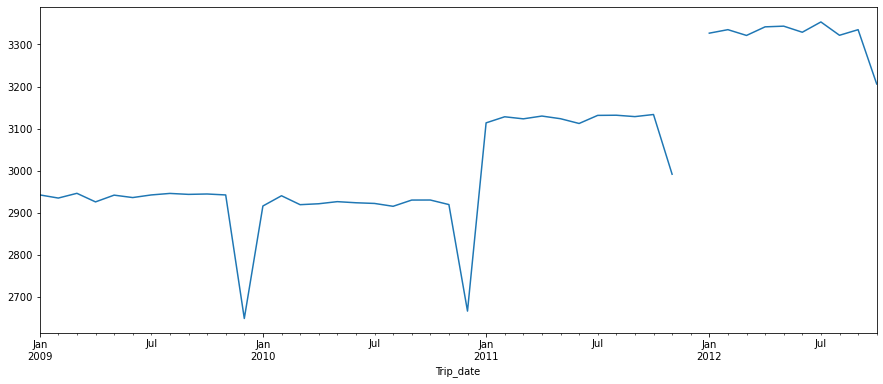

In [51]:
z.plot(figsize=(15, 6))
plt.show()

> RE : BONUS 3  _Creating assumptions using machine learning models

# I'm doing some processing on the data to prepare it to be fitted into the model and tested by the same model*
# The data i'm using is actually the quantity of trips for each month in the 4 years so each value between the 45 value used in the problem is a value that describe the quantity of trips in a specific month, for the machine learning problem i chosen 29 value from the data for training the model & only 16 for testing the model. 

In [74]:
print(len(X))
print(len(train),len(test))

45
29 16


predicted=3080.019796, expected=3112.400000
predicted=3137.342177, expected=3131.612903
predicted=3143.434604, expected=3132.000000
predicted=3144.087737, expected=3128.700000
predicted=3144.320771, expected=3133.677419
predicted=3146.078302, expected=2991.961538
predicted=3085.751802, expected=3326.766667
predicted=3177.693413, expected=3335.068966
predicted=3232.137292, expected=3321.354839
predicted=3274.539985, expected=3341.766667
predicted=3311.849668, expected=3343.387097
predicted=3332.361876, expected=3328.966667
predicted=3359.147883, expected=3353.354839
predicted=3368.479146, expected=3321.741935
predicted=3356.403752, expected=3335.033333
predicted=3360.038633, expected=3206.142857
Test MSE: 9250.824


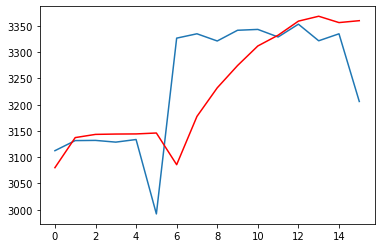

In [71]:
X = z.values
X = X[np.logical_not(np.isnan(X))]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train ]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)

print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# The 9250.824 is a good MSE for validation by testing i observe that the model do a good regression & the plot shows, We can see the values show some trend and are in the correct scale & seasonality

** <h2>PART4 : CONCLUSION </h2>**

**The main purpose of this analysis is being able to extract the insight from data in the most optimized way in term of time & memory costs because it's a large scale processing of data and each query can cost money and cost in global warming**
**The crucial strategies that needed for doing a good management of the nyc taxi traffic
Giving a heat map of new_york taxis based on the fare_amount of taxis
Show the seasonality of the traffic and trying forecast it 
a Heat map of latitude and longitude map view of pickups and dropoffs in the year**

*Those assertions gonna help deciders manage the trafic of taxis for more confortable experience in the city & also preserving the world from global warming*
*And also taxi customers to be aware of the taxi prices depending on locations*